In [1]:
import h5py
import os
import random
from collections import defaultdict
from pathlib import Path
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
import yaml
from dataclasses import dataclass, asdict
from nltk.translate.bleu_score import sentence_bleu
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
# Check if CUDA is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),  # Add batch normalization layer
                nn.ReLU(inplace=True),
                nn.Dropout(0.25)  # Add dropout layer
            )

        # Encoder
        self.enc_conv1 = conv_block(3, 64)
        self.enc_conv2 = conv_block(64, 64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc_conv3 = conv_block(64, 128)
        self.enc_conv4 = conv_block(128, 128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc_conv5 = conv_block(128, 256)
        self.enc_conv6 = conv_block(256, 256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.enc_conv7 = conv_block(256, 512)
        self.enc_conv8 = conv_block(512, 512)
        self.pool4 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(enc1)
        pool1 = self.pool1(enc2)

        enc3 = self.enc_conv3(pool1)
        enc4 = self.enc_conv4(enc3)
        pool2 = self.pool2(enc4)

        enc5 = self.enc_conv5(pool2)
        enc6 = self.enc_conv6(enc5)
        pool3 = self.pool3(enc6)

        enc7 = self.enc_conv7(pool3)
        enc8 = self.enc_conv8(enc7)
        pool4 = self.pool4(enc8)

        return pool4, enc8, enc6, enc4, enc2

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),  # Add batch normalization layer
                nn.ReLU(inplace=True),
                nn.Dropout(0.25)  # Add dropout layer

            )

        def upsample(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        # Decoder
        self.upsample1 = upsample(512, 256, )
        self.dec_conv1 = conv_block(512+256, 256)
        
        self.upsample2 = upsample(256, 128, )
        self.dec_conv2 = conv_block(256+128, 128)

        self.upsample3 = upsample(128, 64)
        self.dec_conv3 = conv_block(128+64, 64)

        self.upsample4 = upsample(64, 32)
        self.dec_conv4 = conv_block(64+32, 32)
        
        self.final_conv = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x, enc8, enc6, enc4, enc2):
        x = self.upsample1(x)
        x = F.interpolate(x, size=enc8.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, enc8), dim=1)
        x = self.dec_conv1(x)


        x = self.upsample2(x)
        x = F.interpolate(x, size=enc6.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, enc6), dim=1)
        x = self.dec_conv2(x)

        x = self.upsample3(x)
        x = torch.cat((x, enc4), dim=1)
        x = self.dec_conv3(x)

        x = self.upsample4(x)
        x = torch.cat((x, enc2), dim=1)
        x = self.dec_conv4(x)

        x = self.final_conv(x)
        return x
        
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(512*18*18, 256),
            nn.BatchNorm1d(256)  # Add batch normalization layer
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128)  # Add batch normalization layer
        )
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# x = torch.randn(1, 3, 300, 300)
        
# # Instantiate the encoder and decoder
# encoder = Encoder()
# decoder = Decoder()
# # Pass the tensor through the encoder
# pool4, enc8, enc6, enc4, enc2 = encoder(x)
# output = decoder(pool4, enc8, enc6, enc4, enc2)

# # Pass the encoded tensor and skip connections through the decoder

# print(f"Input shape: {output.shape}")

class AAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.discriminator = Discriminator()

    def forward(self, x):
        enc_out, enc8, enc6, enc4, enc2 = self.encoder(x)
        decoded = self.decoder(enc_out, enc8, enc6, enc4, enc2)
        validity = self.discriminator(enc_out)
        return decoded, validity

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import itertools

# Path to your images
path = "/Users/raju/Raju Mac/UW/Research Paper/HistoPatch/image"

# Create a subfolder and move all images into it
os.makedirs(os.path.join(path, "class1"), exist_ok=True)
for file in os.listdir(path):
    if file.endswith(('.png', '.jpg', '.jpeg')):
        os.rename(os.path.join(path, file), os.path.join(path, "class1", file))

# Define a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize images to 300x300
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(path, transform=transform)

batch_size = 16  # Updated batch size

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = AAE().to(device)

# Define a loss function and optimizer
adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.MSELoss()

optimizer_G = torch.optim.Adam(itertools.chain(model.encoder.parameters(), model.decoder.parameters()), lr=0.001)
optimizer_D = torch.optim.Adam(model.discriminator.parameters(), lr=0.001)

# Initialize lists to save losses
G_losses = []
D_losses = []

# Train the model
num_epochs = 50  # Updated number of epochs
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):  # we don't need labels
        # Move tensors to the right device
        # Inside the loop, check memory usage if needed
        current_allocated_memory = torch.cuda.memory_allocated()
        current_reserved_memory = torch.cuda.memory_reserved()
        images = images.to(device)
        # 1) reconstruction + generator loss
        optimizer_G.zero_grad()
        enc_out, enc8, enc6, enc4, enc2 = model.encoder(images)
        decoded = model.decoder(enc_out, enc8, enc6, enc4, enc2)
        validity = model.discriminator(enc_out)
        G_loss = 0.2*adversarial_loss(validity, torch.ones_like(validity)) + 0.8*reconstruction_loss(decoded, images)
        G_loss.backward()
        optimizer_G.step()

        # 2) discriminator loss
        optimizer_D.zero_grad()
        real_z = torch.randn(images.size(0), 512*18*18).to(device)
        fake_z = enc_out.view(enc_out.size(0), -1).detach()
        real_loss = adversarial_loss(model.discriminator(real_z), torch.ones(images.size(0), 1).to(device))
        fake_loss = adversarial_loss(model.discriminator(fake_z), torch.zeros(images.size(0), 1).to(device))
        D_loss = 0.5*(real_loss + fake_loss)
        D_loss.backward()
        optimizer_D.step()
        # print(i, G_loss.item(), D_loss.item())
    # Save losses for this epoch
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], G_loss: {G_loss.item():.4f}, D_loss: {D_loss.item():.4f}')
    print()
# Save the model weights
# torch.save(model.state_dict(), "/home/smturaju/Downloads/model/model_weights.pth")

# # Save the losses
# torch.save(G_losses, "/home/smturaju/Downloads/model/G_losses.pth")

# torch.save(D_losses, "/home/smturaju/Downloads/model/D_losses.pth")

Epoch [1/50], G_loss: 0.2265, D_loss: 0.7029

Epoch [2/50], G_loss: 0.2154, D_loss: 0.6621

Epoch [3/50], G_loss: 0.1718, D_loss: 0.6736

Epoch [4/50], G_loss: 0.1561, D_loss: 0.6647



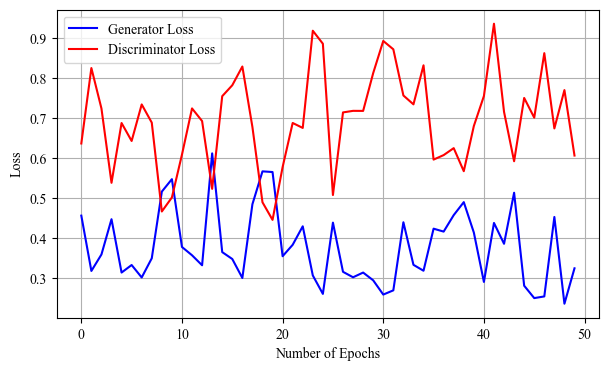

In [3]:
import torch
import matplotlib.pyplot as plt

# Set the global font to be Times New Roman, size 10
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'

# Load the losses
G_losses = torch.load("/Users/raju/Desktop/HistoPatch/256/G_losses.pth")
D_losses = torch.load("/Users/raju/Desktop/HistoPatch/256/D_losses.pth")

# Plot the loss curves
plt.figure(figsize=(7, 4))
plt.plot(G_losses, label='Generator Loss', color='blue')
plt.plot(D_losses, label='Discriminator Loss', color='red')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
# plt.title('Generator and Discriminator Loss Curves')
plt.legend()
plt.grid(True)
plt.savefig('AAE_Loss.pdf', bbox_inches='tight', dpi=320)
plt.show()

In [ ]:
# # Define a transform to convert the images to PyTorch tensors
# transform = transforms.Compose([
#     transforms.Resize((300, 300)),  # Resize images to 300x300
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
# ])

# # Load the dataset
# dataset = datasets.ImageFolder(path, transform=transform)

# # Create a DataLoader
# batch_size = 16  # Updated batch size
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


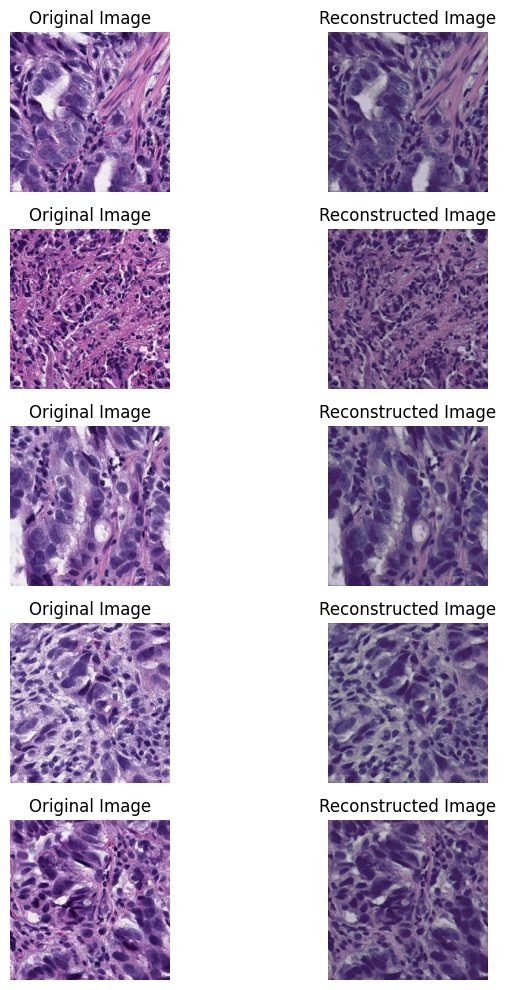

In [44]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ... (previous code)

# Switch to evaluation mode
model.eval()

# Take a few images from the dataset for visualization
num_images_to_visualize = 5
visualization_dataloader = DataLoader(dataset, batch_size=num_images_to_visualize, shuffle=True)
images, _ = next(iter(visualization_dataloader))

# Move images to the device
images = images.to(device)

# Perform forward pass to get reconstructed images
with torch.no_grad():
    enc_out, enc8, enc6, enc4, enc2= model.encoder(images)
    reconstructed_images = model.decoder( enc_out, enc8, enc6, enc4, enc2)

# Visualize the original and reconstructed images
fig, axes = plt.subplots(num_images_to_visualize, 2, figsize=(8, 2*num_images_to_visualize))
for i in range(num_images_to_visualize):
    axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0).numpy())
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_images[i].cpu().detach().permute(1, 2, 0).numpy())
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
###############Final Model

In [ ]:
import h5py
import os
import random
from collections import defaultdict
from pathlib import Path
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
import yaml
from dataclasses import dataclass, asdict
from nltk.translate.bleu_score import sentence_bleu
import torch
from torch import nn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from pathlib import Path
import tensorflow as tf
from torchsummary import summary
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),  # Add batch normalization layer
                nn.ReLU(inplace=True),
                nn.Dropout(0.25)  # Add dropout layer
            )

        def upsample(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc_conv1 = conv_block(3, 64)
        self.enc_conv2 = conv_block(64, 64)
        self.enc_conv3 = conv_block(64, 64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc_conv4 = conv_block(64, 128)
        self.enc_conv5 = conv_block(128, 128)
        self.enc_conv6 = conv_block(128, 128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc_conv7 = conv_block(128, 256)
        self.enc_conv8 = conv_block(256, 256)
        self.enc_conv9 = conv_block(256, 256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Decoder
        self.upsample1 = upsample(256, 128)
        self.dec_conv1 = conv_block(256+128, 128)
        self.dec_conv11 = conv_block(128, 128)

        self.upsample2 = upsample(128, 64)
        self.dec_conv2 = conv_block(128+64, 64)
        self.dec_conv22 = conv_block(64, 64)
        
        self.upsample3 = upsample(64, 32)
        self.dec_conv3 = conv_block(64+32, 32)
        self.dec_conv33 = conv_block(32, 32)
        
        self.final_conv = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(enc1)
        enc3 = self.enc_conv3(enc2)
        pool1 = self.pool1(enc3)

        enc4 = self.enc_conv4(pool1)
        enc5 = self.enc_conv5(enc4)
        enc6 = self.enc_conv6(enc5)
        pool2 = self.pool2(enc6)

        enc7 = self.enc_conv7(pool2)
        enc8 = self.enc_conv8(enc7)
        enc9 = self.enc_conv9(enc8)
        pool3 = self.pool3(enc9)

        # Decoder
        x = self.upsample1(pool3)
        x = F.interpolate(x, size=enc9.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, enc9), dim=1)
        x = self.dec_conv1(x)
        x = self.dec_conv11(x)

        x = self.upsample2(x)
        x = torch.cat((x, enc6), dim=1)
        x = self.dec_conv2(x)
        x = self.dec_conv22(x)

        x = self.upsample3(x)
        x = torch.cat((x, enc3), dim=1)
        x = self.dec_conv3(x)
        x = self.dec_conv33(x)
        x = self.final_conv(x)
        return x
        
# # Assume `encoder` is an instance of your encoder
# encoder = UNET()

# # You need to specify the input size
# input_size = (3, 300, 300)  # (channels, height, width)
# summary(encoder, input_size)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Path to your images
path = "/Users/raju/Desktop/HistoPatch/imagedata"

# Create a subfolder and move all images into it
os.makedirs(os.path.join(path, "class1"), exist_ok=True)
for file in os.listdir(path):
    if file.endswith(('.png', '.jpg', '.jpeg')):
        os.rename(os.path.join(path, file), os.path.join(path, "class1", file))


# Define a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize images to 300x300
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the dataset
dataset = datasets.ImageFolder(path, transform=transform)

# Create a DataLoader
batch_size = 16  # Updated batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = UNET().to(device)

# Define a loss function and optimizer
criterion = torch.nn.MSELoss()  # or another appropriate loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Updated learning rate

# Train the model
num_epochs = 10  # Updated number of epochs
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):  # we don't need labels
        # Move tensors to the right device
        images = images.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)  # assuming you want to do image reconstruction
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ... (previous code)

# Switch to evaluation mode
model.eval()

# Take a few images from the dataset for visualization
num_images_to_visualize = 5
visualization_dataloader = DataLoader(dataset, batch_size=num_images_to_visualize, shuffle=True)
images, _ = next(iter(visualization_dataloader))

# Move images to the device
images = images.to(device)

# Perform forward pass to get reconstructed images
reconstructed_images = model(images)

# Visualize the original and reconstructed images
fig, axes = plt.subplots(num_images_to_visualize, 2, figsize=(8, 2*num_images_to_visualize))
for i in range(num_images_to_visualize):
    axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0).numpy())
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_images[i].cpu().detach().permute(1, 2, 0).numpy())
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
